In [1]:
import keras

from keras import layers
from keras import ops
import tensorflow as tf
import numpy as np
import imageio
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
batch_size = 4
num_channels = 1
num_classes = 5
image_size = 512
latent_dim = 256 # TUNE

data_dir = "/kaggle/input/lung-ds/Full_slice/train" ###

generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes

datagen = ImageDataGenerator(
    rescale=1./255
)

image_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode="grayscale",
    seed=42            
)

images, labels = next(image_generator)

Found 1890 images belonging to 5 classes.


In [ ]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((512, 512, discriminator_in_channels)),
        #layers.Conv2D(16, (4, 4), strides=(2, 2), padding="same"), 
        #layers.LeakyReLU(negative_slope=0.2),
        #layers.Dropout(0.4),
        
        layers.Conv2D(64, kernel_size=4, strides=2, padding='same'),
        layers.LeakyReLU(alpha=0.2),
        #layers.Dropout(0.3),

        layers.Conv2D(128, kernel_size=4, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        #layers.Dropout(0.3),

        layers.Conv2D(256, kernel_size=4, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        #layers.Dropout(0.3),
        
        layers.Conv2D(512, kernel_size=4, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        #layers.Dropout(0.3),

        layers.Conv2D(1024, kernel_size=4, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        #layers.Dropout(0.3),

        layers.Flatten(),
        #layers.Dense(128, activation='relu'), # NOW
        layers.Dense(1, activation='sigmoid')
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        #keras.layers.InputLayer((generator_in_channels,)),
        
        # Increase feature map size
        layers.Dense(16 * 16 * 256, input_dim=generator_in_channels, use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Reshape((16, 16, 256)),

        # Upsample progressively to 512x512
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(16, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Conv2DTranspose(8, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(1, kernel_size=3, strides=1, padding='same', activation='tanh')
    ],
    name="generator",
)

class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(42)
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = ops.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = ops.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = ops.concatenate(
            [generated_images, image_one_hot_labels], -1
        )
        real_image_and_labels = ops.concatenate([real_images, image_one_hot_labels], -1)
        combined_images = ops.concatenate(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = ops.concatenate(
                [fake_images, image_one_hot_labels], -1
            )
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)

initial_lr_generator = 0.0002
#lr_schedule_generator = ExponentialDecay(
#    initial_learning_rate=initial_lr_generator,
#    decay_steps=1000,    # Adjust based on your training iterations
#    decay_rate=0.98,
#    staircase=True
#)
generator_optimizer = keras.optimizers.Adam(learning_rate=initial_lr_generator, beta_1=0.5)

initial_lr_discriminator = 0.0002
#lr_schedule_discriminator = ExponentialDecay(
#    initial_learning_rate=initial_lr_discriminator,
#    decay_steps=1000,    # Adjust as needed
#    decay_rate=0.96,
#    staircase=True
#)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=initial_lr_discriminator, beta_1=0.5)


cond_gan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

cond_gan.fit(image_generator, epochs=20)

trained_gen = cond_gan.generator

# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 9  # @param {type:"integer"}

# Sample noise for the interpolation.
interpolation_noise = keras.random.normal(shape=(1, latent_dim))
interpolation_noise = ops.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = ops.reshape(interpolation_noise, (num_interpolation, latent_dim))

Epoch 1/20
945/945 ━━━━━━━━━━━━━━━━━━━━ 70s 64ms/step - d_loss: 0.3610 - g_loss: 3.9517
Epoch 2/20
945/945 ━━━━━━━━━━━━━━━━━━━━ 60s 64ms/step - d_loss: 0.2588 - g_loss: 3.5348
Epoch 3/20
945/945 ━━━━━━━━━━━━━━━━━━━━ 60s 64ms/step - d_loss: 7.3758 - g_loss: 11.9005
Epoch 4/20
945/945 ━━━━━━━━━━━━━━━━━━━━ 60s 64ms/step - d_loss: 0.4469 - g_loss: 2.4121
Epoch 5/20
945/945 ━━━━━━━━━━━━━━━━━━━━ 60s 64ms/step - d_loss: 0.3430 - g_loss: 2.8497
Epoch 6/20
945/945 ━━━━━━━━━━━━━━━━━━━━ 61s 65ms/step - d_loss: 0.2075 - g_loss: 3.4576
Epoch 7/20
945/945 ━━━━━━━━━━━━━━━━━━━━ 60s 64ms/step - d_loss: 0.2720 - g_loss: 4.2664
Epoch 8/20
945/945 ━━━━━━━━━━━━━━━━━━━━ 60s 64ms/step - d_loss: 0.3020 - g_loss: 4.0746
Epoch 9/20
945/945 ━━━━━━━━━━━━━━━━━━━━ 60s 64ms/step - d_loss: 0.2204 - g_loss: 4.2309
Epoch 10/20
945/945 ━━━━━━━━━━━━━━━━━━━━ 60s 64ms/step - d_loss: 6.9383 - g_loss: 18.1509
Epoch 11/20
945/945 ━━━━━━━━━━━━━━━━━━━━ 60s 64ms/step - d_loss: 0.2414 - g_loss: 3.5161
Epoch 12/20
945/945 ━━━━━━━━

In [4]:
def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = ops.cast(first_label, "float32")
    second_label = ops.cast(second_label, "float32")

    # Calculate the interpolation vector between the two labels.
    percent_second_label = ops.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = ops.cast(percent_second_label, "float32")
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = ops.concatenate([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake


start_class = 0  # @param {type:"slider", min:0, max:9, step:1}
end_class = 4  # @param {type:"slider", min:0, max:9, step:1}

fake_images = interpolate_class(start_class, end_class)

fake_images *= 255.0
converted_images = fake_images.astype(np.uint8)
converted_images = ops.image.resize(converted_images, (512, 512)).numpy().astype(np.uint8)
imageio.mimsave("animation.gif", converted_images[:, :, :, 0], fps=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


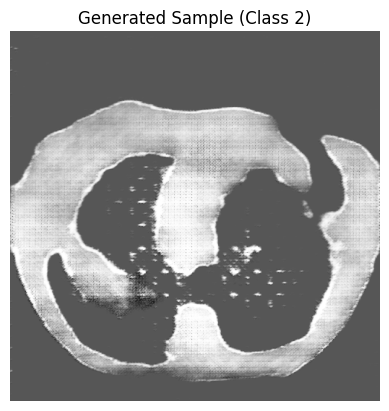

In [7]:
num_samples = 10

# Generate a random noise vector for each sample
noise = np.random.normal(0, 1, (num_samples, latent_dim))

# Specify desired class labels (for example, all samples as class '2')
# You can also randomly select labels if you wish.
labels = np.full((num_samples,), 2)  # change 2 to any integer from 0 to 4

# Convert the labels to one-hot encoded vectors
labels_onehot = tf.keras.utils.to_categorical(labels, num_classes=num_classes)

# Concatenate the noise and one-hot labels along axis=1 to form the generator input
gen_input = np.concatenate([noise, labels_onehot], axis=1)

# Generate images using the generator
generated_images = generator.predict(gen_input)

# The output images will be in the same range as your generator's activation output (e.g., [-1, 1]).
# To display them, you might rescale them to [0,1]:
generated_images = 0.5 * generated_images + 0.5

# (Optional) Visualize one of the generated images
import matplotlib.pyplot as plt
plt.imshow(generated_images[0, :, :, 0], cmap='gray')
plt.title(f"Generated Sample (Class {labels[0]})")
plt.axis('off')
plt.show()